# Feature Extractor Code 

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

2025-03-12 16:48:27.959962: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 16:48:27.969385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741808907.981752 1658950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741808907.985337 1658950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 16:48:27.997893: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
####################################


# CHANGE MASK PROPORTION HERE

MASK_PROPORTION = 0.50


####################################



# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 50

# AUGMENTATION
IMAGE_SIZE = 128  # We will resize input images to this size.
CHANNELS = 1
PATCH_SIZE = 16  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2


# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 16
DEC_PROJECTION_DIM = 8
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

## Load data


In [3]:
import os
import tensorflow as tf



base_dir = 'png_512'

# Create a dataset from images in the directory
dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir),              # Base directory
    labels='inferred',                   # Infer labels from directory structure
    color_mode="grayscale",
    label_mode=None,                     # No labels
    image_size=(IMAGE_SIZE, IMAGE_SIZE), # Image size
    batch_size=BATCH_SIZE,               # Batch size
    shuffle=False,                       # Do not shuffle the data
    interpolation='bilinear'
)


# Debugging: Print the shape and type of the data
for images in dataset.take(1):
    print(f"Shape of images: {images.shape}")
    print(f"Type of images: {type(images)}")



Found 70684 files.
Shape of images: (128, 128, 128, 1)
Type of images: <class 'tensorflow.python.framework.ops.EagerTensor'>


W0000 00:00:1741808911.379550 1658950 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-03-12 16:48:31.453777: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Functions

These functions are identical to those used in the pre-training code.


In [4]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
#             layers.RandomFlip("horizontal"),
#             layers.RandomRotation(factor=0.15),  # Rotação aleatória entre -30 e 30 graus (fator = 0.15 para 15 graus)
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0),
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [5]:

class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE,
                 channels = CHANNELS, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.channels = channels

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * channels))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, self.channels))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, self.channels))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

In [6]:

class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        channels = CHANNELS,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * channels]), trainable=True
        )
        

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        self.rand_indices = tf.argsort(
            tf.random.uniform(shape=(1, self.num_patches)), axis=-1
        )
        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices
    
    def get_indices(self, batch_size):
        
        rand_indices = tf.tile(self.rand_indices, [128, 1])

        mask_indices = rand_indices[:, :self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask:]

        return mask_indices, unmask_indices


    def get_ordered_indices(self, batch_size):
        # Create sequential indices.
        sequential_indices = tf.range(self.num_patches, dtype=tf.int32)

        # Separate even and odd indices.
        even_indices = sequential_indices[::2]
        odd_indices = sequential_indices[1::2]

        # Interleave even and odd indices.
        ordered_indices = tf.concat([even_indices, odd_indices], axis=0)

        # Repeat indices to match the batch size.
        ordered_indices = tf.tile(ordered_indices[tf.newaxis, :], [batch_size, 1])

        # Split indices into mask_indices and unmask_indices.
        mask_indices = ordered_indices[:, :self.num_mask]
        unmask_indices = ordered_indices[:, self.num_mask:]

        return mask_indices, unmask_indices

    def get_sorted_indices(self, batch_size):
        # Create sequential indices.
        sequential_indices = tf.range(self.num_patches, dtype=tf.int32)

        # Calculate the midpoint.
        midpoint = self.num_patches // 2

        # Calculate the distance of each index from the midpoint.
        distances = tf.abs(sequential_indices - midpoint)

        # Sort indices based on distances in descending order.
        sorted_indices = tf.argsort(-distances)

        # Repeat indices to match the batch size.
        sorted_indices = tf.tile(sorted_indices[tf.newaxis, :], [batch_size, 1])

        # Split indices into mask_indices and unmask_indices.
        mask_indices = sorted_indices[:, :self.num_mask]
        unmask_indices = sorted_indices[:, self.num_mask:]

        return mask_indices, unmask_indices

    
    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx




In [7]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [8]:

def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")


In [9]:

def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE,
    channels = CHANNELS
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * channels, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, channels))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


In [10]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}


In [11]:
# Taking a batch of test inputs to measure model's progress.
images = next(iter(dataset))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image, cmap = 'gray')
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image, cmap = 'gray')
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image, cmap = 'gray')
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

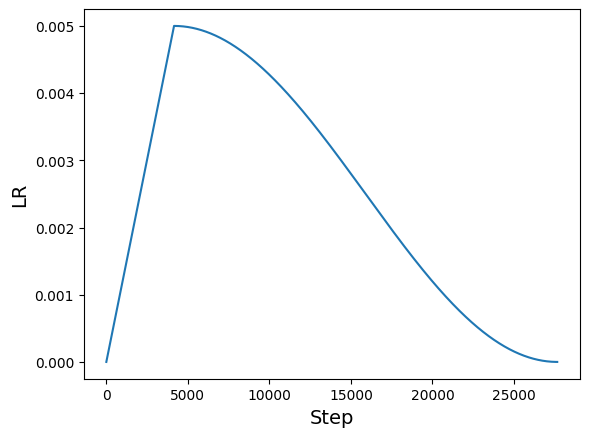

In [12]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(dataset)) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

## Load Weights from Pre-trained Models

In [13]:
# instantiate the models

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

optimizer = tf.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

#Compile and pretrain the model.
model.compile( optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"])

### Patch Encoder

In [14]:
new_model_checkpoint_pe = tf.train.Checkpoint(variables=model.patch_encoder.trainable_variables)


checkpoint_directory = '/home/alcindo/projeto/masked-autoencoders-cows/pre-trained-models/mp50/pe/'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_directory)
if latest_checkpoint:
    new_model_checkpoint_pe.restore(latest_checkpoint)


### Encoder


In [15]:
new_model_checkpoint_encoder = tf.train.Checkpoint(variables=model.encoder.trainable_variables)


checkpoint_directory = '/home/alcindo/projeto/masked-autoencoders-cows/pre-trained-models/mp50/encoder/'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_directory)
if latest_checkpoint:
    new_model_checkpoint_encoder.restore(latest_checkpoint)

### Decoder

In [16]:

new_model_checkpoint_decoder = tf.train.Checkpoint(variables=model.decoder.trainable_variables)


checkpoint_directory = '/home/alcindo/projeto/masked-autoencoders-cows/pre-trained-models/mp50/decoder/'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_directory)

if latest_checkpoint:
    new_model_checkpoint_decoder.restore(latest_checkpoint)

In [17]:
# Measure its performance.
loss, mae = model.evaluate(dataset)
print(f"Loss: {loss}")
print(f"MAE: {mae}")

/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:665: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:640: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


553/553 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - mae: 0.3084 - loss: 0.2358
Loss: 0.24150408804416656
MAE: {'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.31597888469696045>}


In [ ]:
# del(model)


Idx chosen: 5


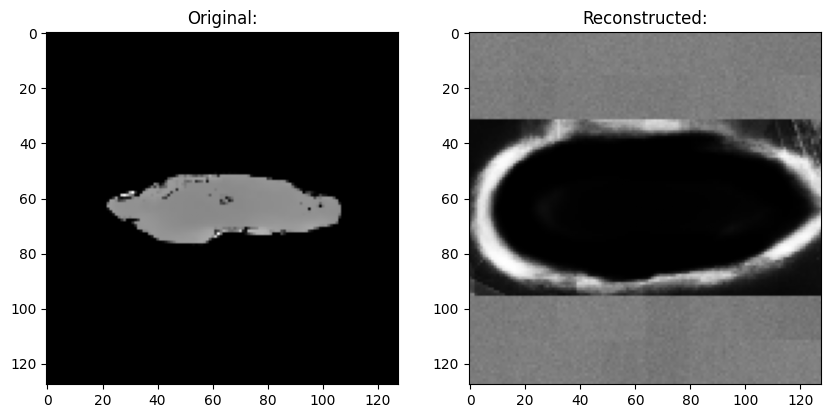

In [28]:
images = next(iter(dataset))

augmented_images = test_augmentation_model(images[21:29])

# Patch the augmented images.
patches = patch_layer(augmented_images)

# Encode the patches.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = model.patch_encoder(patches)

# Pass the unmaksed patche to the encoder.
encoder_outputs = model.encoder(unmasked_embeddings)

# # Create the decoder inputs.
encoder_outputs = encoder_outputs + unmasked_positions
decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
decoder_outputs = model.decoder(decoder_inputs)

idx = random.choice(range(8))

print(f"\nIdx chosen: {idx}")
original_image = augmented_images[idx]
reconstructed_image = decoder_outputs[idx]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(original_image, cmap = 'gray')
ax[0].set_title("Original:")

ax[1].imshow(reconstructed_image, cmap = 'gray')
ax[1].set_title("Reconstructed:")

plt.show()
plt.close()

In [19]:
import tensorflow as tf
from tqdm import tqdm

# Assuming you have a train_dataset containing multiple images

# Initialize an empty list to store the results for each image
processed_images = []

# Use tqdm to create a progress bar for the loop
for images in tqdm(dataset, total=len(dataset)):
    # Perform the same operations as in your code snippet

    # Apply augmentation to the image
    augmented_images = test_augmentation_model(images)

    # Patch the augmented images
    patches = patch_layer(augmented_images)

    # Encode the patches
    (
        unmasked_embeddings,
        masked_embeddings,
        unmasked_positions,
        mask_indices,
        unmask_indices,
    ) = model.patch_encoder(patches)

    # Pass the unmasked patches to the encoder
    encoder_outputs = model.encoder(unmasked_embeddings)

    # Append the processed image to the list
    processed_images.append(encoder_outputs)

# processed_images now contains the processed data for the entire dataset, and you will see a progress bar as the loop iterates.


 34%|███▍      | 187/553 [00:16<00:31, 11.46it/s]


KeyboardInterrupt: 

In [ ]:
# Initialize a new list to store the reshaped tensors
reshaped_outputs = []

# Use tqdm to create a progress bar for the loop
for output in tqdm(processed_images, total=len(processed_images), desc="Reshaping"):
    reshaped_tensor = tf.reshape(output, [output.shape[0], 32 * 16])
    reshaped_outputs.append(reshaped_tensor)

In [ ]:
import pandas as pd
import numpy as np

# Assuming reshaped_outputs is a list of shape (553, 128, 768)

# Convert the list to a NumPy array
reshaped_array = np.array(reshaped_outputs[:-1])

# Reshape the array to have shape (553*128, 768)
reshaped_array = reshaped_array.reshape(-1, 512)

# Create a DataFrame from the reshaped array
df = pd.DataFrame(reshaped_array)


In [ ]:
a = df.iloc[23]
a = np.array(a)
a = a.reshape(1,32,16)
a = tf.convert_to_tensor(a)

# # Create the decoder inputs.
encoder_outputs = a + unmasked_positions
decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
decoder_outputs = model.decoder(decoder_inputs)


original_image = augmented_images[0]
reconstructed_image = decoder_outputs[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(original_image, cmap = 'gray')
ax[0].set_title("Original:")

ax[1].imshow(reconstructed_image, cmap = 'gray')
ax[1].set_title("Resonstructed:")

plt.show()
plt.close()

In [ ]:
# Append the last batch with size 28
last_batch = reshaped_outputs[-1]  # Assuming the last element is the last batch
last_batch = last_batch[:28]  # Keep only the first 28 elements
last_batch = np.array(last_batch)

# Append the last batch to the DataFrame
df = df.append(pd.DataFrame(last_batch), ignore_index=True)

In [ ]:
df

In [ ]:
all_files = [filename for filename in os.listdir('png_512') if filename.endswith('.png')]
len(all_files)

In [ ]:

# Remove "resultado_" prefix and ".png" suffix from all elements in the list
cleaned_list = [filename.replace('resultado_', '').replace('.png', '') for filename in all_files]


cleaned_list = sorted(cleaned_list)


In [ ]:
df['Filenames'] = cleaned_list

In [ ]:
df.to_csv('/content/drive/My Drive/Colab Notebooks/tc/resultados/output_dim16_mp50.csv', index=False)